In [2]:
import numpy as np
import sympy as sp
import fk
import vk
import ik
import matplotlib.pyplot as plt
import time

def wrap_to_pi(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [ ]:
#Symbolic DH Kinematics Unusued

theta0 = sp.symbols('theta0')
theta1 = sp.symbols('theta1')
theta2 = sp.symbols('theta2')

dh = sp.Matrix([[0, -.03825, 0, np.pi/2],
               [theta0-np.pi/2, 0, .170, -np.pi/2],
               [theta1, 0, .180, np.pi/2],
               [theta2, 0, .180, -np.pi/2]])

def dh2mat(dh):
    T = sp.eye(4)
    for i in range(dh.shape[0]):
        T = sp.MatMul(T, dhrow2mat(dh[i, :]))
    return T

def dhrow2mat(row):
    theta=row[0]
    d=row[1]
    a=row[2]
    alpha=row[3]
    return sp.Matrix([[sp.cos(theta), -sp.sin(theta)*sp.cos(alpha), sp.sin(theta)*sp.sin(alpha), a*sp.cos(theta)],
                     [sp.sin(theta), sp.cos(theta)*sp.cos(alpha), -sp.cos(theta)*sp.sin(alpha), a*sp.sin(theta)],
                     [0, sp.sin(alpha), sp.cos(alpha), d],
                     [0, 0, 0, 1]])
dhmat= dh2mat(dh)
dh2mat_lambdified = sp.lambdify([theta0, theta1, theta2], dhmat, 'numpy')

jacobian_dh2mat = sp.Matrix([
    dhmat.diff(theta0)[0:3, 3].T,
    dhmat.diff(theta1)[0:3, 3].T,
    dhmat.diff(theta2)[0:3, 3].T
]).T

jacobian_dh2mat_lambdified = sp.lambdify([theta0, theta1, theta2], jacobian_dh2mat, 'numpy')



In [ ]:
cycles = np.array([])
execution_times = np.array([])
execution_hz = np.array([])
goal_pos=np.array([])
goal_angs=np.array([])
educated_guess_angs=np.array([])
educated_guess_pos=np.array([])
educated_guess_error=np.array([])
result_angs=np.array([])
result_pos=np.array([])


for n in range(50000):
    angs=np.random.uniform(-np.pi/3,np.pi/3,(3,1))
    pos=fk.arm2fk(angs[0],angs[1],angs[2])[0:3,3]
    goal_pos=np.append(goal_pos,pos)
    goal_angs=np.append(goal_angs,angs)
    theta0_d = np.arctan2(pos[0],-pos[2])*1.25
    theta2_d = -np.arctan2(pos[0],-pos[2])/2
    theta1_d = np.arcsin(pos[1]/(.18+.18*np.cos(theta2_d))) * np.sign(theta0_d)
    educated_guess_angs=np.append(educated_guess_angs,[theta0_d,theta1_d,theta2_d])
    educated_guess_pos=np.append(educated_guess_pos,fk.arm2fk(theta0_d,theta1_d,theta2_d)[0:3,3])
    educated_guess_error=np.append(educated_guess_error,np.linalg.norm(pos-educated_guess_pos[n*3:(n+1)*3]))
    start_time = time.time_ns()
    ikangs=ik.arm2ik(pos[0],pos[1],pos[2])
    execution_time =time.time_ns()-start_time
    execution_time*=1e-9
    result_angs=np.append(result_angs,ikangs[0:3])
    result_pos=np.append(result_pos,fk.arm2fk(ikangs[0],ikangs[1],ikangs[2])[0:3,3])
    cycles=np.append(cycles,ikangs[3])
    execution_times=np.append(execution_times,execution_time)
    execution_hz=np.append(execution_hz,1/(execution_time))


In [31]:
educated_ang_error=np.abs(wrap_to_pi(goal_angs-educated_guess_angs))

print("Mean cycles: ",np.mean(cycles))
print("Max cycles: ",np.max(cycles))
print("Min cycles: ",np.min(cycles))
print("Std cycles: ",np.std(cycles))
print("Median cycles: ",np.median(cycles))
print()

print("Mean execution time (s): ", np.mean(execution_times))
print("Max execution time (s): ", np.max(execution_times))
print("Min execution time (s): ", np.min(execution_times))
print("Std execution time (s): ", np.std(execution_times))
print("Median execution time (s): ", np.median(execution_times))
print()

print("Mean execution hz: ", np.mean(execution_hz))
print("Max execution hz: ", np.max(execution_hz))
print("Min execution hz: ", np.min(execution_hz))
print("Std execution hz: ", np.std(execution_hz))
print("Median execution hz: ", np.median(execution_hz))
print()

result_pos_error = np.linalg.norm(goal_pos.reshape(-1, 3) - result_pos.reshape(-1, 3), axis=1)

print("Mean result pos error: ", np.mean(result_pos_error))
print("Max result pos error: ", np.max(result_pos_error))
print("Min result pos error: ", np.min(result_pos_error))
print("Std result pos error: ", np.std(result_pos_error))
print("Median result pos error: ", np.median(result_pos_error))
print()





Mean cycles:  11.48554
Max cycles:  199.0
Min cycles:  1.0
Std cycles:  13.694554790441344
Median cycles:  5.0

Mean execution time (s):  0.000768174192
Max execution time (s):  0.0130022
Min execution time (s):  0.0
Std execution time (s):  0.0009758503595533217
Median execution time (s):  0.0009996

Mean execution hz:  476800434.36295706
Max execution hz:  999999999.9999999
Min execution hz:  76.9100554590719
Std execution hz:  499461055.3303423
Median execution hz:  1000.3991592645466

Mean result pos error:  2.2034287237886335e-05
Max result pos error:  9.999489955017623e-05
Min result pos error:  2.5278639092424385e-08
Std result pos error:  2.6532189783643234e-05
Median result pos error:  9.521130907204689e-06



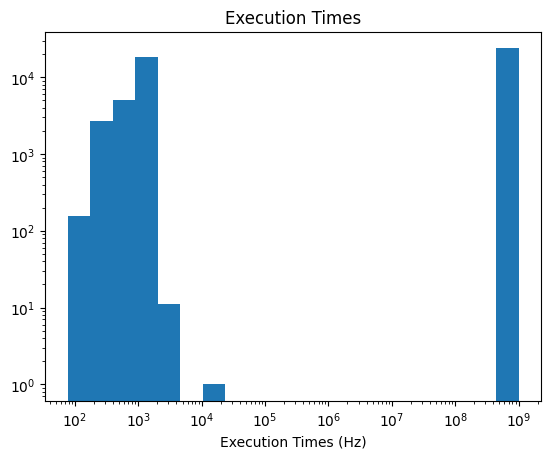

In [29]:
plt.figure()
# Set the x-axis to log scale
plt.xscale('log')
hist, bins, _ = plt.hist(execution_hz, bins=20,log=True)
plt.clf()
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(execution_hz, bins=logbins,log=True)
plt.xscale('log')
plt.title('Execution Times')
plt.xlabel('Execution Times (Hz)')
plt.show()

In [ ]:
# Scew Theory Kinematics Unused

M = np.array([[0, 0, 1, 0],
              [0, 1, 0, 0],
              [-1, 0, 0, -.56825],
              [0, 0, 0, 1]])

S = np.array([[0, 1, 0],
              [-1, 0, -1],
              [0, 0, 0],
              [-.03825, 0, -.38825],
              [0, -.20825, 0],
              [0, 0, 0]])

def fkine(S,M,q):

    T = np.eye(4)
    for i in range(S.shape[1]):
        T = np.dot(T, twist2ht(S[:, i], q[i]))
    T = np.dot(T, M)
    return T

def twist2ht(twist, theta):
    twist = np.array(twist)
    omega = twist[0:3]
    v = twist[3:6]
    omega_hat = np.array([[0, -omega[2], omega[1]],
                          [omega[2], 0, -omega[0]],
                          [-omega[1], omega[0], 0]])
    R = np.eye(3) + np.sin(theta) * omega_hat + (1 - np.cos(theta)) * np.dot(omega_hat, omega_hat)
    p = np.dot((np.eye(3) * theta + (1 - np.cos(theta)) * omega_hat + (theta - np.sin(theta)) * np.dot(omega_hat, omega_hat)), v)
    T = np.eye(4)
    T[0:3, 0:3] = R
    T[0:3, 3] = p
    return T

def ikine(T): #Broken

    # print(T)
    # Set the bounds 
    lower_bound = -np.pi / 6 
    upper_bound = np.pi / 6 
    # # Generate a 3x1 random array within the specified bounds 
    q = (upper_bound - lower_bound) * np.random.rand(3) + lower_bound
    
     
    for i in range(1000000):
        # print(q)
        TG = fk.arm2fk(q[0],q[1],q[2])
        e = TG[0:3,3] - T[0:3,3]
        # print(T0)
        # print(e)
        # print(np.linalg.norm(e))
        if np.linalg.norm(e) < 1e-3:
            print("converged")
            print(q)
            print(TG)
            print(i)
            
            break
        J = vk.arm2vk(q[0],q[1],q[2]) #jacobian(S, q)

        # lambd = 0.1
        # dampedPseduoinv = np.linalg.pinv(J@J.T+lambd**2*np.eye(3))
        
        dq = np.linalg.pinv(J) @ np.vstack(e)
        q += dq.T[0]/1.5
        # print(q)
        
    
    
        
    return wrap_to_pi(q)





def jacobian(S, q):
    J = np.zeros((6, S.shape[1]))
    T = np.eye(4)
    for i in range(S.shape[1]):
        T = T@twist2ht(S[:, i], q[i])
        Ad_T_Si = adjoint(T)@S[:, i]
        J[:, i] = Ad_T_Si
    return J

def adjoint(T): 
    """ Given a homogeneous transformation matrix T, calculate the corresponding 6x6 adjoint transformation matrix. """ 
    R = T[:3, :3] 
    p = T[:3, 3] 
    s = np.array([[0, -p[2], p[1]], 
                  [p[2], 0, -p[0]], 
                  [-p[1], p[0], 0]]) 
    AdT = np.block([[R, np.zeros((3, 3))],
                    [s @ R, R]]) 
    return AdT
            
def ht2twist(T):
    R = T[0:3, 0:3]
    p = T[0:3, 3]
    omega_hat = np.array([[0, -R[2, 1], R[1, 0]],
                          [R[2, 0], 0, -R[0, 2]],
                          [-R[1, 0], R[0, 1], 0]])
    omega = np.array([R[2, 1], R[0, 2], R[1, 0]])
    theta = np.arccos((np.trace(R) - 1) / 2)
    v = np.dot(np.linalg.inv(np.eye(3) * theta + (1 - np.cos(theta)) * omega_hat + (theta - np.sin(theta)) * np.dot(omega_hat, omega_hat)), p)
    twist = np.zeros(6)
    twist[0:3] = omega
    twist[3:6] = v
    return twist



def jacobe(S, M, q): 
    # Initialize the Jacobian matrix 
    J_b = np.zeros((6, len(q))) 
    # # Initialize the transformation matrix 
    T = np.eye(4) 
    B = S.copy() 
    # Loop through each joint 
    for i in range(len(q) - 1, -2, -1): 
        B[:, i] = twistspace2body(S[:, i], M) 
        # Update the transformation matrix 
        if i < len(q) - 1: 
            T = T @ twist2ht(B[:, i + 1], -q[i + 1]) 
            # Update the Jacobian matrix           
            J_b[:, i] = adjoint(T) @ B[:, i]
    return J_b

def skew(vector):
    """Create a skew-symmetric matrix from a 3-vector."""
    return np.array([[0, -vector[2], vector[1]],
                     [vector[2], 0, -vector[0]],
                     [-vector[1], vector[0], 0]])

def twistspace2body(V_s, T):
    """
    Convert a twist from the space frame to the body frame.
    
    Parameters:
    V_s -- Twist in the space frame (6x1 numpy array).
    T -- Homogeneous transformation matrix from the body frame to the space frame (4x4 numpy array).
    
    Returns:
    V_b -- Twist in the body frame (6x1 numpy array).
    """
    # T is the homogeneous transformation matrix from the body frame to the space frame
    R = T[:3, :3]  # Rotation matrix
    p = T[:3, 3]   # Position vector
    Adj_T = np.block([[R, skew(p) @ R], [np.zeros((3, 3)), R]])  # Adjoint representation of T
    V_b = Adj_T.T @ V_s
    return V_b


# q0=[np.pi/3,0,np.pi/6]
# T=fk.arm2fk(q0[0],q0[1],q0[2])
# print("Init angle",q0)
# print("Goal Pos",T)
# q=ikine(T)
# T2=fk.arm2fk(q[0],q[1],q[2])

# print("IK angles",q)
# print("IK angles Fk",T2)
# J=jacobian(S,[0,0,0])
# Je=jacobe(S,M,[0,0,0*np.pi/2])
# print(vk.arm2vk(q0[0],q0[1],q0[2]))
# print(Je)